In [105]:
import pymc as pm
import arviz as az

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt

In [23]:
d1994 = pd.read_csv("1994.csv")
d1995 = pd.read_csv("1995.csv")
d1996 = pd.read_csv("1996.csv")
d1997 = pd.read_csv("1997.csv")
d1998 = pd.read_csv("1998.csv")
d1999 = pd.read_csv("1999.csv")
d2000 = pd.read_csv("2000.csv")
d2001 = pd.read_csv("2001.csv")
d2002 = pd.read_csv("2002.csv")
d2003 = pd.read_csv("2003.csv")
d2004 = pd.read_csv("2004.csv")
d2005 = pd.read_csv("2005.csv")
d2006 = pd.read_csv("2006.csv")
d2007 = pd.read_csv("2007.csv")
d2008 = pd.read_csv("2008.csv")
d2009 = pd.read_csv("2009.csv")
d2010 = pd.read_csv("2010.csv")
d2011 = pd.read_csv("2011.csv")
d2012 = pd.read_csv("2012.csv")
d2013 = pd.read_csv("2013.csv")
d2014 = pd.read_csv("2014.csv")
d2015 = pd.read_csv("2015.csv")
d2016 = pd.read_csv("2016.csv")
d2017 = pd.read_csv("2017.csv")
d2018 = pd.read_csv("2018.csv")
d2019 = pd.read_csv("2019.csv")
d2020 = pd.read_csv("2020.csv")
d2021 = pd.read_csv("2021.csv")
d2022 = pd.read_csv("2022.csv")

In [24]:
d = pd.concat(
    [
        d1994, d1995, d1996, d1997, 
        d1998, d1999, d2000, d2001,
        d2002, d2003, d2004, d2005, 
        d2006, d2007, d2008, d2009,
        d2010, d2011, d2012, d2013,
        d2014, d2015, d2016, d2017,
        d2018, d2019, d2020, d2021,
        d2022
        ])


In [27]:
#Cleaning up the dataframe
d.rename(columns = {d.columns[0]:"date", d.columns[1]:"time", d.columns[2]: "temp"}, inplace = True)

In [29]:
d = d.loc[:,["date", "time", "temp"]]
d.loc[d.temp == "-","temp"] = np.nan
d.temp = d.temp.astype("float")

d.reset_index(inplace = True)

In [76]:
#Formatting year, month, day columns
d.date = pd.to_datetime(d.date)
d["year"] = d.date.dt.year
d["month"] = d.date.dt.month
d["day"] = d.date.dt.day
d["doy"] = d.date.dt.dayofyear





In [125]:
#Calculating averages for each day for every date in the dataset
daily_average = d.groupby(by = ["year", "month", "day","doy"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
daily_average.sort_values(by = ["year","month","doy"], inplace = True)
daily_average.reset_index(inplace = True)


#Calculating montly averages, year by year
monthly_average = d.groupby(by = ["year","month"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
monthly_average.sort_values(by = ["year", "month"], inplace = True)
monthly_average.reset_index(inplace = True)
monthly_average.dropna(inplace = True)
monthly_average.year = pd.Categorical(monthly_average.year)
ma2 = monthly_average.groupby(by = "month", as_index = False).agg(Mean = ("Mean", np.mean))
ma2.sort_values(by = "month", inplace = True)
ma2.reset_index(inplace = True)

#Calculating yearly averages
yearly_average = d.groupby(by = ["year"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
yearly_average.sort_values(by = ["year"], inplace = True)
yearly_average.reset_index(inplace = True)


In [78]:
da2 = daily_average.groupby(by = ["doy","month"], as_index = False).agg(Mean = ("Mean", np.mean), Sd = ("Mean", np.std))
da2.sort_values(by = ["month","doy"], inplace = True)
da2.reset_index(inplace = True)

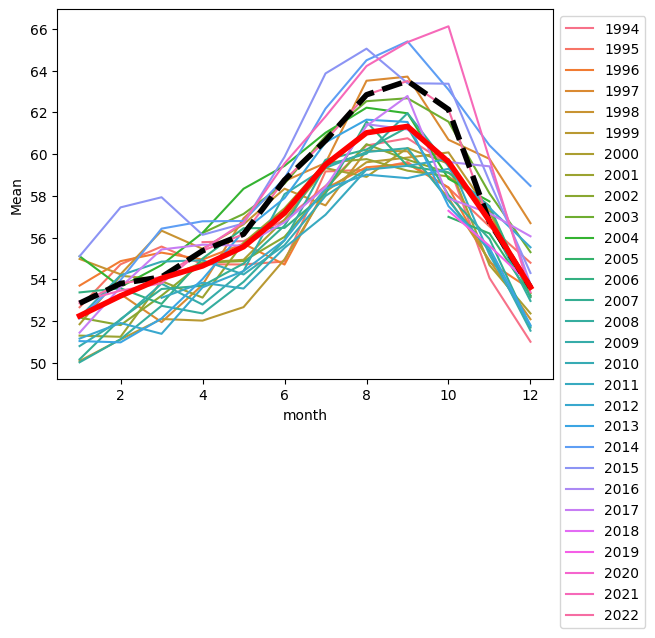

In [127]:
ax = sns.lineplot(data = monthly_average, x = "month", y = "Mean", hue = "year")
sns.lineplot(data = monthly_average.loc[monthly_average.year == 2022,:], x = "month", y = "Mean", linewidth = 4, color = "black", linestyle = "dashed")
sns.lineplot(data = ma2, x = "month", y = "Mean", linewidth = 4, color = "red")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))